#preprocessing pipeline demo !!!

This notebook demonstrates the full EMG preprocessing pipeline: Band-pass filtering → Wavelet denoising → Windowing → Feature extraction

Using a single callable function (`preprocess_emg`) using a fixed configuration to ensure reproducibility.


In [49]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

#since notebook is inside data_processing, go up to repo root
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "data_processing":
    PROJECT_ROOT = PROJECT_ROOT.parent

#addd repo root to path (the folder that CONTAINS data_processing/)
sys.path.insert(0, str(PROJECT_ROOT))

print("Project root added to path:", PROJECT_ROOT)

from data_processing.preprocess import preprocess_emg
from data_processing.preprocess_config import PreprocessConfig


Project root added to path: /Users/emily/Neurorehab Device/psr-pipeline


#PREPROCESSING CONFIG
putting all proprocessing hyperparameters in a single config object 

In [50]:
config = PreprocessConfig(
    low=20.0,
    high=450.0,
    order=4,
    zero_phase=True,
    wavelet="sym4",
    level=4,
    threshold_mode="soft",
    threshold_method="universal",
    noise_est="median",
    window_size=0.2,
    overlap=0.5,
    padding=False,
    return_windows=False
)
config

PreprocessConfig(low=20.0, high=450.0, order=4, zero_phase=True, wavelet='sym4', level=4, threshold_mode='soft', threshold_method='universal', noise_est='median', window_size=0.2, overlap=0.5, padding=False, return_windows=False)

#EXAMPLE INPUT DATA 
Generated multichannel semg signals with a simulated activation burst

In [51]:
def make_fake_subject(n_samples, n_channels=8, fs=1000, seed=0):
    rng = np.random.default_rng(seed)
    emg = 0.05 * rng.standard_normal((n_samples, n_channels))
    t = np.arange(n_samples) / fs
    burst = np.sin(2 * np.pi * 60 * t) * ((t > 1.0) & (t < 2.0))
    emg[:, 0] += 0.2 * burst
    return emg, t

fs = 1000
emg_s1, t1 = make_fake_subject(n_samples=6000, n_channels=8, fs=fs, seed=1)
emg_s2, t2 = make_fake_subject(n_samples=12000, n_channels=8, fs=fs, seed=2)


#RAW SIGNAL VISUAL: stacked channels of the simulated sEMG input

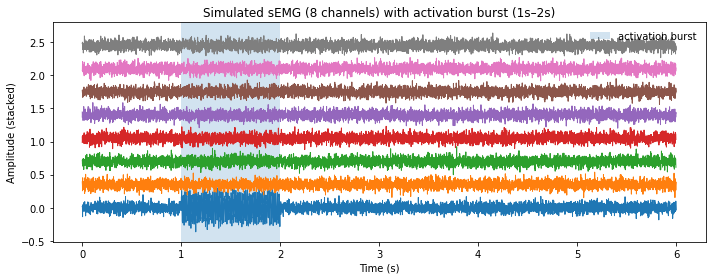

In [52]:
plt.figure(figsize=(10, 4))
offset = 0.35
for ch in range(emg_s1.shape[1]):
    plt.plot(t1, emg_s1[:, ch] + ch * offset, linewidth=1)

plt.title("Simulated sEMG (8 channels) with activation burst (1s–2s)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (stacked)")
plt.axvspan(1.0, 2.0, alpha=0.2, label="activation burst")
plt.legend(loc="upper right", frameon=False)
plt.tight_layout()
plt.show()


In [53]:
X1 = preprocess_emg(emg_s1, fs=fs, config=config)
X2 = preprocess_emg(emg_s2, fs=fs, config=config)

print("Subject 1 features:", X1.shape)
print("Subject 2 features:", X2.shape)
print("Feature dims equal?", X1.shape[1] == X2.shape[1])

Subject 1 features: (59, 96)
Subject 2 features: (119, 96)
Feature dims equal? True


#OUTPUT FEATURE MATRIX: each column represents a time window, each row is a feature, bright regions correspond to muscle activation.

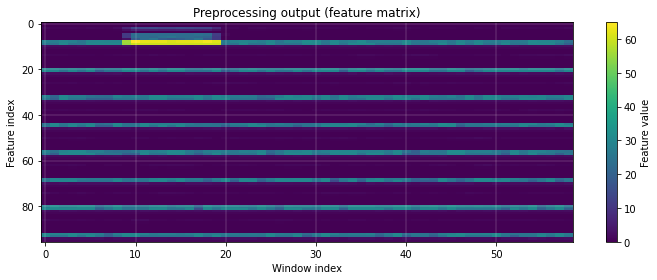

In [54]:
plt.figure(figsize=(10, 4))
plt.grid(color='white', linestyle='-', linewidth=0.2)
plt.imshow(X1.T, aspect="auto", interpolation="nearest")
plt.title("Preprocessing output (feature matrix)")
plt.xlabel("Window index")
plt.ylabel("Feature index")
plt.colorbar(label="Feature value")
plt.tight_layout()
plt.show()


In [55]:
expected_dim = emg_s1.shape[1] * 12  #8 * 12 = 96
assert X1.shape[1] == expected_dim
assert X2.shape[1] == expected_dim
print("YAY output dimensions validated across subjects.")


YAY output dimensions validated across subjects.
